In [1]:
from sortedcontainers import SortedList as ost
from math import floor,ceil,log,sqrt
from collections import deque
import numpy as np
from statistics import mean,variance
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable
from pymonad.tools import curry
from functools import partial

In [2]:
@dataclass
class sumstat :
    y : float 
    sy : float
    syy : float

In [3]:
def normal_mean_cost(sumstats,a,b) :    
    val = sumstats[b+1].sy - sumstats[a].sy
    val *= val
    val /= (b - a + 1)
    val = -val
    val += sumstats[b+1].syy - sumstats[a].syy
    return val

In [4]:
# patterns : [closure,class,object,monad<writer>?]
def class_windowed_sumstats(wsize) : # sumstats class (a factory)
    sumstats = deque([sumstat(0.0,0.0,0.0)],maxlen = wsize)
    def update(y) :
        last = sumstats[-1]
        sumstats.append(sumstat(y,last.sy + y,last.syy + y*y))
        # TODO - if Y is full - normalize
        return sumstats,update
    return sumstats,update

In [5]:
def class_windowed_sumstats_cost(cost_function,wsize) :
    sumstats,update_sumstats = class_windowed_sumstats(wsize)
    def value(a,b) :
        return cost_function(sumstats,a,b)
    def update(x) :
        nonlocal update_sumstats
        sumstats,update_sumstats = update_sumstats(x)
        return value,update,None,len(sumstats)-1
    return value,update,None,0
        

In [6]:
def fix_left(cost_function,position) :
    f,dom,size = cost_function
    def value(i) :
        return f(position,i)
    return value,range(size),size

In [7]:
def fix_right(cost_function,position) :
    f,dom,size = cost_function
    def value(i) :
        return f(i,position)
    return value,range(size),size

In [8]:
def split_left_right_sum(cost) :
    fl,domain,size = fix_left(cost,0)
    fr,_,_ = fix_right(cost,size-1)
    def value(i) :
        if i == 0 :
            return fr(i)
        else :
            return fl(i) + fr(i)
    return(value,domain,size)

In [9]:
def left_right_sum(fl,fr,i) :
    if i == 0 :
        return fr(i)
    else :
        return fl(i) + fr(i)

In [10]:
def split(cost,penalty) : 
    f,dom,_ = cost
    value,position = min([(f(i),i) for i in dom])
    if f(0) - value > penalty :
        return value + penalty,position
    return value,0

In [11]:
def windowed_function_graph(wsize) :
    graph = deque([],maxlen=wsize)
    def value(i) :
        return graph[i]
    def push(x) :
        graph.append(x)
        return value,push,range(len(graph)),len(graph)
    return value,push,range(0),0

In [12]:
np.random.seed(0)
Z = [float(z) for z in list(np.random.normal(0, 1, 1000)) + list(np.random.normal(1, 1, 1000))] #  + list(np.random.normal(0, 1, 1000))]

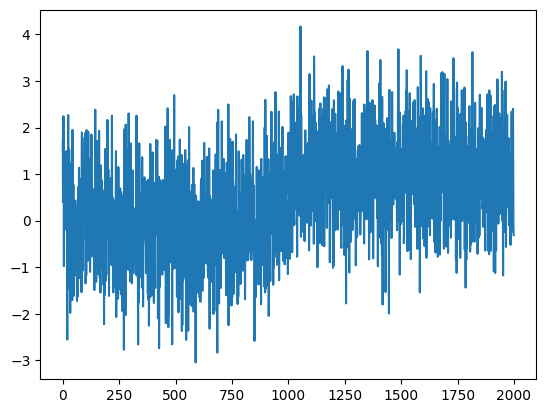

In [13]:
plt.plot(Z)

In [14]:
history = list()
value,update,domain,size = class_windowed_sumstats_cost(normal_mean_cost,len(Z))
for z in Z :
    value,update,domain,size = update(z)
    value,domain,size = split_left_right_sum((value,domain,size))
    history.append(split((value,domain,size),2*log(len(Z))))

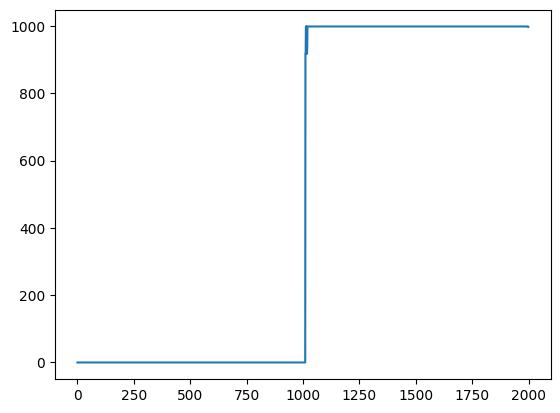

In [15]:
plt.plot([pos for _,pos in history])


In [43]:
def class_amoc(cost) :
    c_value,c_update,c_domain,c_size = cost
    def update(x,penalty) :
        nonlocal c_value,c_update,c_domain,c_size
        c_value,c_update,c_domain,c_size = c_update(x)
        cf = split_left_right_sum((c_value,c_domain,c_size))
        return split(cf,penalty),update
    return None,update

In [17]:
normal_mean = curry(2,class_windowed_sumstats_cost)(normal_mean_cost)

In [18]:
wsize = len(Z)
penalty = 2*log(wsize)
_,update = class_amoc(normal_mean(len(Z)))
history = list()

for z in Z :
    value,update = update(z,penalty)
    history.append(value)

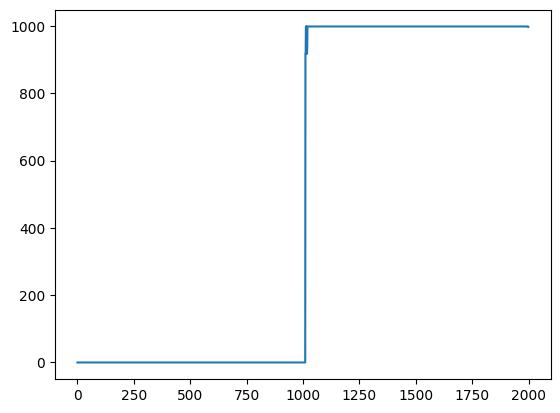

In [19]:
plt.plot([pos for _,pos in history])

In [42]:
history[1114]

(1091.857311573425, 999)

In [20]:
value,push,domain,size = windowed_function_graph(10)

In [21]:
_,push,_,_ = windowed_function_graph(10)
for i in range(10) :
    value,push,domain,size = push(i)

In [22]:
blob = curry(3,left_right_sum)(value,value)

In [23]:
blob(9)

18

In [ ]:
def class_op(cost,temp_wsize) :
    c_value,c_update,c_domain,c_size = cost(temp_wsize)
    fl,push = windowed_function_graph(temp_wsize)
    def update(x,penalty) :
        nonlocal c_value,c_update,c_domain,c_size
        c_value,c_update,c_domain,c_size = c_update(x)
        fr,_,_ = fix_right(c_value,c_size-1)
        
        cf = split_left_right_sum((c_value,c_domain,c_size))
        return split(cf,penalty),update
    return None,update